Logs:
[2023/09/05] 
- Implementation of AR(p) in `from statsmodels.tsa.arima_model import ARMA, ARIMA`.    
  is deprecated. Use SARIMAX.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error, mean_absolute_error


In [11]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})


**Function declarations**

In [6]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(10, 4)):
  fig, ax = plt.subplots(figsize=figsize)

  ax.plot(x, y)

  formatter = mdates.DateFormatter("%Y")
  locator = mdates.YearLocator(base=2)
  # locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
  ax.xaxis.set_major_formatter(formatter)
  ax.xaxis.set_major_locator(locator)

  ax.grid("on")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  for j, label in enumerate(ax.get_xticklabels()):
    label.set_rotation(40)
    label.set_horizontalalignment('right')

  plt.show(fig)



## 5.1 Predicting the average weekly foot traffic in a retail store

Suppose that you want to forecast the average weekly foot traffic in 
a retail store so that the store manager can better manage the staff's schedule.
Note that this is fictional data.

In [9]:
file_path = "./datasets/foot_traffic_with_date.csv"
df_foot_traffic = pd.read_csv(file_path, parse_dates=[0])
# df_foot_traffic = pd.read_csv(file_path)
df_foot_traffic


,date,foot_traffic
0,2000-01-02,500.496714
1,2000-01-09,500.522366
2,2000-01-16,501.426876
3,2000-01-23,503.295990
4,2000-01-30,504.132695
...,...,...
995,2019-01-27,706.009031
996,2019-02-03,705.610549
997,2019-02-10,704.771335
998,2019-02-17,703.559920


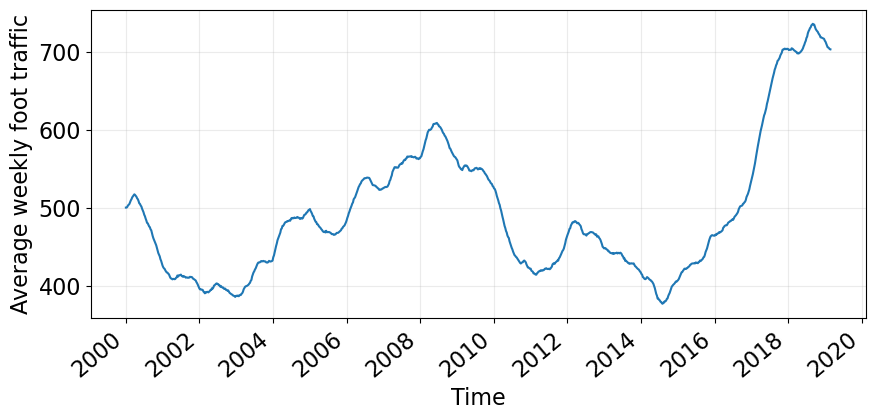

In [12]:
plot_time_series(df_foot_traffic["date"], df_foot_traffic["foot_traffic"],  
  "Time", "Average weekly foot traffic")

## 5.2 Defining the autoregressive process

**Autoregressive process**    
An autoregressive process is a regression of a variable against itself.    
In a time series, this means that the present value is linearly dependent
on its past values.   

The autoregressive process is denoted as $\text{AR(p)}$, where $p$ is the order.   
The general expression of an $\text{AR}(p)$ model is
$$
  y_t = C + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \ldots + \phi_p y_{t-p} + \epsilon_t
$$

The random walk process is a special case of an autoregressive process,
where the order $p = 1$, and $\phi_1 = 1$.

## 5.3 Finding the order of a stationary autoregressive process

## 5.4 Forecasting an autoregressive process

## 5.5 Next steps

## Fix some bugs in data

Add date to `foot_traffic.csv`. Frequency of the time is weekly.

In [5]:
file_path = "./datasets/foot_traffic.csv"
df_foot_traffic_with_date = pd.read_csv(file_path)

df_foot_traffic_with_date["date"] \
  = pd.date_range(start="2000-01-01", periods=len(df_foot_traffic_with_date), freq="W")
df_foot_traffic_with_date = df_foot_traffic_with_date[["date", "foot_traffic"]]

df_foot_traffic_with_date.to_csv("./datasets/foot_traffic_with_date.csv", index=False)

df_foot_traffic_with_date



,date,foot_traffic
0,2000-01-02,500.496714
1,2000-01-09,500.522366
2,2000-01-16,501.426876
3,2000-01-23,503.295990
4,2000-01-30,504.132695
...,...,...
995,2019-01-27,706.009031
996,2019-02-03,705.610549
997,2019-02-10,704.771335
998,2019-02-17,703.559920
